In [2]:
## Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchaudio
import torchaudio.transforms as transforms
import os 
import numpy as np
from tqdm import tqdm
from RSRTxReadBin.RTxReadBin import RTxReadBin
import pandas as pd

In [3]:
## Functions and classes
# Custom Dataset
class SpeechDataset(Dataset):
    def __init__(self, path = "waveforms_r6p8_fast/", file_list=[], ch=0, n_mels=64, n_fft=2048, hop_length=512):
        self.file_list = file_list
        self.ch = ch
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.path = path
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        waveform, sample_rate = self.load_waveform(file_path, self.ch)
        mel_spectrogram = self.transform_audio(waveform, sample_rate) # No use the spectrogram
        label = self.get_label_from_filename(file_path)
        return mel_spectrogram, label

    def load_waveform(self, file_path, ch):
        wfm_data, b, meta_data = RTxReadBin(self.path+file_path, nNofChannels=2)
        wfm_data = np.array(wfm_data[:, 0, ch])[:int(len(wfm_data[:, 0, ch]) / 2)]
        sample_rate = int(1 / meta_data["Resolution"])
        waveform = torch.from_numpy(wfm_data).float()
        return waveform, sample_rate

    def transform_audio(self, waveform, sample_rate):
        transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length)
        mel_spectrogram = transform(waveform.unsqueeze(0))
        return mel_spectrogram

    def get_label_from_filename(self, filename):
        return int(os.path.basename(filename).split('_')[0])

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        device = next(model.parameters()).device
        print(device)
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
        
        
# Training Function
def train_model_cp(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        device = next(model.parameters()).device
        print(device)
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
        torch.save(model, f"r1p9_checkpoint/CNN_filter_r1p9_softmax_arb_e{epoch}_loss{epoch_loss:.2f}.pt")


In [8]:
## r6p8 model on MTJ ##

# Network Definition
class LargerSpeechCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(LargerSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 1 * 1, 64)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = self.pool(x)
        #x = F.relu(self.conv3(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        # x = self.softmax(x)
        return x


# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p8_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p8_arb2.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [04:44<1:53:40, 284.20s/it]

Epoch 0/24, Loss: 1.7577
cuda:0


  8%|▊         | 2/25 [09:07<1:44:13, 271.87s/it]

Epoch 1/24, Loss: 1.3237
cuda:0


 12%|█▏        | 3/25 [13:37<1:39:26, 271.21s/it]

Epoch 2/24, Loss: 1.0962
cuda:0


 16%|█▌        | 4/25 [18:07<1:34:38, 270.43s/it]

Epoch 3/24, Loss: 0.9962
cuda:0


 20%|██        | 5/25 [22:43<1:30:49, 272.49s/it]

Epoch 4/24, Loss: 0.8920
cuda:0


 24%|██▍       | 6/25 [27:13<1:26:00, 271.62s/it]

Epoch 5/24, Loss: 0.7845
cuda:0


 28%|██▊       | 7/25 [31:48<1:21:53, 272.99s/it]

Epoch 6/24, Loss: 0.7783
cuda:0


 32%|███▏      | 8/25 [35:49<1:14:24, 262.61s/it]

Epoch 7/24, Loss: 0.6986
cuda:0


 36%|███▌      | 9/25 [39:48<1:08:06, 255.39s/it]

Epoch 8/24, Loss: 0.6598
cuda:0


 40%|████      | 10/25 [43:34<1:01:30, 246.05s/it]

Epoch 9/24, Loss: 0.6263
cuda:0


 44%|████▍     | 11/25 [47:24<56:18, 241.33s/it]  

Epoch 10/24, Loss: 0.6663
cuda:0


 48%|████▊     | 12/25 [51:05<50:55, 235.03s/it]

Epoch 11/24, Loss: 0.6039
cuda:0


 52%|█████▏    | 13/25 [54:56<46:48, 234.02s/it]

Epoch 12/24, Loss: 0.5788
cuda:0


 56%|█████▌    | 14/25 [58:35<42:03, 229.40s/it]

Epoch 13/24, Loss: 0.5489
cuda:0


 60%|██████    | 15/25 [1:02:31<38:33, 231.34s/it]

Epoch 14/24, Loss: 0.5284
cuda:0


 64%|██████▍   | 16/25 [1:06:26<34:51, 232.42s/it]

Epoch 15/24, Loss: 0.5485
cuda:0


 68%|██████▊   | 17/25 [1:10:36<31:41, 237.68s/it]

Epoch 16/24, Loss: 0.4993
cuda:0


 72%|███████▏  | 18/25 [1:14:52<28:22, 243.24s/it]

Epoch 17/24, Loss: 0.5045
cuda:0


 76%|███████▌  | 19/25 [1:18:59<24:26, 244.40s/it]

Epoch 18/24, Loss: 0.5475
cuda:0


 80%|████████  | 20/25 [1:22:57<20:12, 242.51s/it]

Epoch 19/24, Loss: 0.5303
cuda:0


 84%|████████▍ | 21/25 [1:26:47<15:55, 238.75s/it]

Epoch 20/24, Loss: 0.5035
cuda:0


 88%|████████▊ | 22/25 [1:30:45<11:55, 238.41s/it]

Epoch 21/24, Loss: 0.4961
cuda:0


 92%|█████████▏| 23/25 [1:34:57<08:04, 242.49s/it]

Epoch 22/24, Loss: 0.4646
cuda:0


 96%|█████████▌| 24/25 [1:39:30<04:11, 251.56s/it]

Epoch 23/24, Loss: 0.5133
cuda:0


100%|██████████| 25/25 [1:44:17<00:00, 250.32s/it]

Epoch 24/24, Loss: 0.5548


In [ ]:
torch.save(model, "CNN_filter_r6p8_arb2.pt")

In [1]:
## r6p8 model on ARB ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        # x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p8_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p8_softmax_arb.pt")
#model = torch.load("CNN_first_model.pt")

NameError: name 'nn' is not defined

In [11]:
## r1p9 model on MTJ ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.003 # 0.005

# Paths and Data
path = "waveforms_r1p9_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r1p9_softmax_2.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [06:58<2:47:16, 418.20s/it]

Epoch 0/24, Loss: 2.2146
cuda:0


  8%|▊         | 2/25 [12:22<2:19:05, 362.87s/it]

Epoch 1/24, Loss: 2.1184
cuda:0


 12%|█▏        | 3/25 [17:39<2:05:24, 342.03s/it]

Epoch 2/24, Loss: 2.0895
cuda:0


 16%|█▌        | 4/25 [23:01<1:56:55, 334.05s/it]

Epoch 3/24, Loss: 2.0615
cuda:0


 20%|██        | 5/25 [28:19<1:49:23, 328.15s/it]

Epoch 4/24, Loss: 2.0559
cuda:0


 24%|██▍       | 6/25 [33:55<1:44:49, 331.01s/it]

Epoch 5/24, Loss: 2.0064
cuda:0


 28%|██▊       | 7/25 [39:22<1:38:52, 329.57s/it]

Epoch 6/24, Loss: 1.9877
cuda:0


 32%|███▏      | 8/25 [44:48<1:33:03, 328.47s/it]

Epoch 7/24, Loss: 1.9563
cuda:0


 36%|███▌      | 9/25 [50:02<1:26:23, 323.98s/it]

Epoch 8/24, Loss: 1.9315
cuda:0


 40%|████      | 10/25 [55:35<1:21:40, 326.70s/it]

Epoch 9/24, Loss: 1.9177
cuda:0


 44%|████▍     | 11/25 [1:01:09<1:16:44, 328.87s/it]

Epoch 10/24, Loss: 1.9002
cuda:0


 48%|████▊     | 12/25 [1:06:33<1:10:59, 327.62s/it]

Epoch 11/24, Loss: 1.8868
cuda:0


 52%|█████▏    | 13/25 [1:12:09<1:06:01, 330.13s/it]

Epoch 12/24, Loss: 1.8851
cuda:0


 56%|█████▌    | 14/25 [1:17:36<1:00:21, 329.25s/it]

Epoch 13/24, Loss: 1.8843
cuda:0


 60%|██████    | 15/25 [1:23:00<54:33, 327.40s/it]  

Epoch 14/24, Loss: 1.8705
cuda:0


 64%|██████▍   | 16/25 [1:28:27<49:05, 327.29s/it]

Epoch 15/24, Loss: 1.8617
cuda:0


 68%|██████▊   | 17/25 [1:33:50<43:28, 326.08s/it]

Epoch 16/24, Loss: 1.8506
cuda:0


 72%|███████▏  | 18/25 [1:39:13<37:55, 325.13s/it]

Epoch 17/24, Loss: 1.8405
cuda:0


 76%|███████▌  | 19/25 [1:44:41<32:35, 325.96s/it]

Epoch 18/24, Loss: 1.8458
cuda:0


 80%|████████  | 20/25 [1:50:00<27:00, 324.13s/it]

Epoch 19/24, Loss: 1.8391
cuda:0


 84%|████████▍ | 21/25 [1:55:30<21:42, 325.61s/it]

Epoch 20/24, Loss: 1.8320
cuda:0


 88%|████████▊ | 22/25 [2:00:50<16:11, 323.96s/it]

Epoch 21/24, Loss: 1.8395
cuda:0


 92%|█████████▏| 23/25 [2:06:23<10:53, 326.72s/it]

Epoch 22/24, Loss: 1.8285
cuda:0


 96%|█████████▌| 24/25 [2:12:03<05:30, 330.73s/it]

Epoch 23/24, Loss: 1.8206
cuda:0


100%|██████████| 25/25 [2:17:46<00:00, 330.65s/it]

Epoch 24/24, Loss: 1.8153


In [5]:
## r1p9 model on ARB ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r1p9_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r1p9_softmax_arb.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\olive\AppData\Local\anaconda3\envs\Pythonny\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


cuda:0


  4%|▍         | 1/25 [06:53<2:45:28, 413.68s/it]

Epoch 0/24, Loss: 2.1108
cuda:0


  8%|▊         | 2/25 [12:38<2:22:57, 372.93s/it]

Epoch 1/24, Loss: 1.2493
cuda:0


 12%|█▏        | 3/25 [18:30<2:13:13, 363.34s/it]

Epoch 2/24, Loss: 1.0264
cuda:0


 16%|█▌        | 4/25 [24:23<2:05:51, 359.61s/it]

Epoch 3/24, Loss: 0.9570
cuda:0


 20%|██        | 5/25 [30:33<2:01:02, 363.14s/it]

Epoch 4/24, Loss: 0.9610
cuda:0


 24%|██▍       | 6/25 [36:05<1:51:39, 352.58s/it]

Epoch 5/24, Loss: 0.8811
cuda:0


 28%|██▊       | 7/25 [41:47<1:44:44, 349.15s/it]

Epoch 6/24, Loss: 0.9236
cuda:0


 32%|███▏      | 8/25 [47:35<1:38:48, 348.74s/it]

Epoch 7/24, Loss: 0.8132
cuda:0


 36%|███▌      | 9/25 [53:31<1:33:37, 351.06s/it]

Epoch 8/24, Loss: 0.8330
cuda:0


 40%|████      | 10/25 [59:08<1:26:40, 346.72s/it]

Epoch 9/24, Loss: 0.8208
cuda:0


 44%|████▍     | 11/25 [1:05:29<1:23:19, 357.09s/it]

Epoch 10/24, Loss: 0.7876
cuda:0


 48%|████▊     | 12/25 [1:12:12<1:20:24, 371.10s/it]

Epoch 11/24, Loss: 0.7765
cuda:0


 52%|█████▏    | 13/25 [1:18:23<1:14:14, 371.19s/it]

Epoch 12/24, Loss: 0.8332
cuda:0


 56%|█████▌    | 14/25 [1:24:28<1:07:41, 369.21s/it]

Epoch 13/24, Loss: 0.8178
cuda:0


 60%|██████    | 15/25 [1:30:32<1:01:18, 367.82s/it]

Epoch 14/24, Loss: 1.5609
cuda:0


 64%|██████▍   | 16/25 [1:36:21<54:18, 362.09s/it]  

Epoch 15/24, Loss: 0.9822
cuda:0


 68%|██████▊   | 17/25 [1:42:06<47:34, 356.86s/it]

Epoch 16/24, Loss: 1.0652
cuda:0


 72%|███████▏  | 18/25 [1:48:06<41:44, 357.72s/it]

Epoch 17/24, Loss: 0.7800
cuda:0


 76%|███████▌  | 19/25 [1:53:52<35:25, 354.23s/it]

Epoch 18/24, Loss: 0.7996
cuda:0


 80%|████████  | 20/25 [2:00:02<29:55, 359.17s/it]

Epoch 19/24, Loss: 0.8152
cuda:0


 84%|████████▍ | 21/25 [2:05:24<23:12, 348.05s/it]

Epoch 20/24, Loss: 0.7213
cuda:0


 88%|████████▊ | 22/25 [2:11:20<17:31, 350.42s/it]

Epoch 21/24, Loss: 0.7267
cuda:0


 92%|█████████▏| 23/25 [2:17:13<11:41, 350.99s/it]

Epoch 22/24, Loss: 0.7665
cuda:0


 96%|█████████▌| 24/25 [2:23:06<05:51, 351.60s/it]

Epoch 23/24, Loss: 0.7583
cuda:0


100%|██████████| 25/25 [2:28:51<00:00, 357.26s/it]

Epoch 24/24, Loss: 0.7203


In [8]:
## r2p3 model on MTJ ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r2p3_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r2p3_softmax.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [07:30<3:00:09, 450.40s/it]

Epoch 0/24, Loss: 2.1928
cuda:0


  8%|▊         | 2/25 [13:12<2:28:17, 386.85s/it]

Epoch 1/24, Loss: 1.6142
cuda:0


 12%|█▏        | 3/25 [18:53<2:14:09, 365.89s/it]

Epoch 2/24, Loss: 1.5078
cuda:0


 16%|█▌        | 4/25 [24:33<2:04:27, 355.58s/it]

Epoch 3/24, Loss: 1.4442
cuda:0


 20%|██        | 5/25 [30:02<1:55:23, 346.16s/it]

Epoch 4/24, Loss: 1.3782
cuda:0


 24%|██▍       | 6/25 [35:46<1:49:21, 345.33s/it]

Epoch 5/24, Loss: 1.2641
cuda:0


 28%|██▊       | 7/25 [41:19<1:42:22, 341.23s/it]

Epoch 6/24, Loss: 1.1806
cuda:0


 32%|███▏      | 8/25 [47:15<1:37:59, 345.82s/it]

Epoch 7/24, Loss: 1.1269
cuda:0


 36%|███▌      | 9/25 [52:30<1:29:39, 336.21s/it]

Epoch 8/24, Loss: 1.0844
cuda:0


 40%|████      | 10/25 [58:25<1:25:33, 342.26s/it]

Epoch 9/24, Loss: 1.0549
cuda:0


 44%|████▍     | 11/25 [1:04:05<1:19:40, 341.43s/it]

Epoch 10/24, Loss: 1.0342
cuda:0


 48%|████▊     | 12/25 [1:09:50<1:14:13, 342.60s/it]

Epoch 11/24, Loss: 1.0134
cuda:0


 52%|█████▏    | 13/25 [1:15:14<1:07:21, 336.78s/it]

Epoch 12/24, Loss: 0.9925
cuda:0


 56%|█████▌    | 14/25 [1:21:04<1:02:30, 340.94s/it]

Epoch 13/24, Loss: 0.9675
cuda:0


 60%|██████    | 15/25 [1:27:00<57:32, 345.30s/it]  

Epoch 14/24, Loss: 0.9287
cuda:0


 64%|██████▍   | 16/25 [1:32:33<51:15, 341.70s/it]

Epoch 15/24, Loss: 0.9131
cuda:0


 68%|██████▊   | 17/25 [1:38:13<45:30, 341.28s/it]

Epoch 16/24, Loss: 0.8666
cuda:0


 72%|███████▏  | 18/25 [1:43:33<39:02, 334.68s/it]

Epoch 17/24, Loss: 0.8525
cuda:0


 76%|███████▌  | 19/25 [1:49:32<34:12, 342.13s/it]

Epoch 18/24, Loss: 0.8340
cuda:0


 80%|████████  | 20/25 [1:55:18<28:36, 343.39s/it]

Epoch 19/24, Loss: 0.8140
cuda:0


 84%|████████▍ | 21/25 [2:01:02<22:53, 343.30s/it]

Epoch 20/24, Loss: 0.8040
cuda:0


 88%|████████▊ | 22/25 [2:07:04<17:27, 349.19s/it]

Epoch 21/24, Loss: 0.7777
cuda:0


 92%|█████████▏| 23/25 [2:12:49<11:35, 347.80s/it]

Epoch 22/24, Loss: 0.7530
cuda:0


 96%|█████████▌| 24/25 [2:18:50<05:51, 351.78s/it]

Epoch 23/24, Loss: 0.7446
cuda:0


100%|██████████| 25/25 [2:24:57<00:00, 347.88s/it]

Epoch 24/24, Loss: 0.7159


In [9]:
## r2p3 model on ARB ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r2p3_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r2p3_softmax_arb.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [06:04<2:25:39, 364.14s/it]

Epoch 0/24, Loss: 1.8978
cuda:0


  8%|▊         | 2/25 [11:21<2:09:04, 336.72s/it]

Epoch 1/24, Loss: 1.3647
cuda:0


 12%|█▏        | 3/25 [17:00<2:03:48, 337.68s/it]

Epoch 2/24, Loss: 1.1094
cuda:0


 16%|█▌        | 4/25 [23:14<2:03:15, 352.18s/it]

Epoch 3/24, Loss: 1.0869
cuda:0


 20%|██        | 5/25 [29:05<1:57:15, 351.75s/it]

Epoch 4/24, Loss: 0.9756
cuda:0


 24%|██▍       | 6/25 [35:06<1:52:18, 354.65s/it]

Epoch 5/24, Loss: 0.9458
cuda:0


 28%|██▊       | 7/25 [41:02<1:46:33, 355.20s/it]

Epoch 6/24, Loss: 1.0628
cuda:0


 32%|███▏      | 8/25 [46:53<1:40:14, 353.80s/it]

Epoch 7/24, Loss: 0.9662
cuda:0


 36%|███▌      | 9/25 [52:55<1:35:02, 356.39s/it]

Epoch 8/24, Loss: 1.0264
cuda:0


 40%|████      | 10/25 [58:55<1:29:22, 357.52s/it]

Epoch 9/24, Loss: 0.8357
cuda:0


 44%|████▍     | 11/25 [1:04:51<1:23:18, 357.01s/it]

Epoch 10/24, Loss: 0.9960
cuda:0


 48%|████▊     | 12/25 [1:10:26<1:15:54, 350.38s/it]

Epoch 11/24, Loss: 0.8285
cuda:0


 52%|█████▏    | 13/25 [1:16:33<1:11:05, 355.44s/it]

Epoch 12/24, Loss: 0.7566
cuda:0


 56%|█████▌    | 14/25 [1:22:15<1:04:25, 351.45s/it]

Epoch 13/24, Loss: 0.7177
cuda:0


 60%|██████    | 15/25 [1:28:11<58:47, 352.74s/it]  

Epoch 14/24, Loss: 0.7586
cuda:0


 64%|██████▍   | 16/25 [1:34:07<53:02, 353.66s/it]

Epoch 15/24, Loss: 0.6750
cuda:0


 68%|██████▊   | 17/25 [1:39:46<46:33, 349.15s/it]

Epoch 16/24, Loss: 0.6198
cuda:0


 72%|███████▏  | 18/25 [1:45:47<41:10, 352.93s/it]

Epoch 17/24, Loss: 0.8541
cuda:0


 76%|███████▌  | 19/25 [1:51:35<35:08, 351.42s/it]

Epoch 18/24, Loss: 0.7413
cuda:0


 80%|████████  | 20/25 [1:57:32<29:25, 353.19s/it]

Epoch 19/24, Loss: 0.8684
cuda:0


 84%|████████▍ | 21/25 [2:03:16<23:20, 350.20s/it]

Epoch 20/24, Loss: 0.6254
cuda:0


 88%|████████▊ | 22/25 [2:09:02<17:27, 349.15s/it]

Epoch 21/24, Loss: 0.6146
cuda:0


 92%|█████████▏| 23/25 [2:14:40<11:31, 345.80s/it]

Epoch 22/24, Loss: 0.6249
cuda:0


 96%|█████████▌| 24/25 [2:20:24<05:45, 345.22s/it]

Epoch 23/24, Loss: 0.5714
cuda:0


100%|██████████| 25/25 [2:26:12<00:00, 350.89s/it]

Epoch 24/24, Loss: 0.5661


In [10]:
## r6p7 model on MTJ ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p7_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p7_softmax.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [03:24<1:21:53, 204.72s/it]

Epoch 0/24, Loss: 1.9182
cuda:0


  8%|▊         | 2/25 [06:46<1:17:46, 202.90s/it]

Epoch 1/24, Loss: 1.3432
cuda:0


 12%|█▏        | 3/25 [10:12<1:14:56, 204.40s/it]

Epoch 2/24, Loss: 1.1525
cuda:0


 16%|█▌        | 4/25 [13:37<1:11:36, 204.57s/it]

Epoch 3/24, Loss: 1.0313
cuda:0


 20%|██        | 5/25 [17:01<1:08:04, 204.24s/it]

Epoch 4/24, Loss: 0.9612
cuda:0


 24%|██▍       | 6/25 [20:26<1:04:50, 204.74s/it]

Epoch 5/24, Loss: 0.8777
cuda:0


 28%|██▊       | 7/25 [23:52<1:01:34, 205.23s/it]

Epoch 6/24, Loss: 0.8147
cuda:0


 32%|███▏      | 8/25 [27:15<57:54, 204.36s/it]  

Epoch 7/24, Loss: 0.7841
cuda:0


 36%|███▌      | 9/25 [30:38<54:25, 204.09s/it]

Epoch 8/24, Loss: 0.7253
cuda:0


 40%|████      | 10/25 [34:03<51:03, 204.22s/it]

Epoch 9/24, Loss: 0.6967
cuda:0


 44%|████▍     | 11/25 [37:26<47:33, 203.85s/it]

Epoch 10/24, Loss: 0.6603
cuda:0


 48%|████▊     | 12/25 [40:52<44:18, 204.47s/it]

Epoch 11/24, Loss: 0.6219
cuda:0


 52%|█████▏    | 13/25 [44:19<41:04, 205.37s/it]

Epoch 12/24, Loss: 0.5970
cuda:0


 56%|█████▌    | 14/25 [47:45<37:39, 205.42s/it]

Epoch 13/24, Loss: 0.5802
cuda:0


 60%|██████    | 15/25 [51:13<34:21, 206.10s/it]

Epoch 14/24, Loss: 0.5513
cuda:0


 64%|██████▍   | 16/25 [54:39<30:56, 206.26s/it]

Epoch 15/24, Loss: 0.5314
cuda:0


 68%|██████▊   | 17/25 [58:03<27:24, 205.59s/it]

Epoch 16/24, Loss: 0.5172
cuda:0


 72%|███████▏  | 18/25 [1:01:29<23:59, 205.59s/it]

Epoch 17/24, Loss: 0.4943
cuda:0


 76%|███████▌  | 19/25 [1:04:53<20:31, 205.23s/it]

Epoch 18/24, Loss: 0.4709
cuda:0


 80%|████████  | 20/25 [1:08:20<17:08, 205.73s/it]

Epoch 19/24, Loss: 0.4488
cuda:0


 84%|████████▍ | 21/25 [1:11:47<13:44, 206.06s/it]

Epoch 20/24, Loss: 0.4493
cuda:0


 88%|████████▊ | 22/25 [1:15:12<10:17, 205.84s/it]

Epoch 21/24, Loss: 0.4354
cuda:0


 92%|█████████▏| 23/25 [1:18:38<06:51, 205.86s/it]

Epoch 22/24, Loss: 0.4142
cuda:0


 96%|█████████▌| 24/25 [1:22:05<03:26, 206.02s/it]

Epoch 23/24, Loss: 0.4157
cuda:0


100%|██████████| 25/25 [1:25:31<00:00, 205.25s/it]

Epoch 24/24, Loss: 0.3902


In [9]:
## r6p7 model on ARB ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p7_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p7_softmax_arb.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [04:44<1:53:53, 284.73s/it]

Epoch 0/24, Loss: 1.8379
cuda:0


  8%|▊         | 2/25 [08:08<1:30:59, 237.36s/it]

Epoch 1/24, Loss: 1.4107
cuda:0


 12%|█▏        | 3/25 [11:29<1:20:52, 220.57s/it]

Epoch 2/24, Loss: 1.4102
cuda:0


 16%|█▌        | 4/25 [14:51<1:14:40, 213.34s/it]

Epoch 3/24, Loss: 1.1168
cuda:0


 20%|██        | 5/25 [18:16<1:10:06, 210.31s/it]

Epoch 4/24, Loss: 1.0005
cuda:0


 24%|██▍       | 6/25 [21:40<1:05:55, 208.19s/it]

Epoch 5/24, Loss: 1.0304
cuda:0


 28%|██▊       | 7/25 [25:02<1:01:49, 206.08s/it]

Epoch 6/24, Loss: 0.8085
cuda:0


 32%|███▏      | 8/25 [28:27<58:19, 205.83s/it]  

Epoch 7/24, Loss: 0.8018
cuda:0


 36%|███▌      | 9/25 [31:52<54:46, 205.43s/it]

Epoch 8/24, Loss: 0.9800
cuda:0


 40%|████      | 10/25 [35:14<51:07, 204.47s/it]

Epoch 9/24, Loss: 0.8696
cuda:0


 44%|████▍     | 11/25 [38:39<47:44, 204.59s/it]

Epoch 10/24, Loss: 0.7472
cuda:0


 48%|████▊     | 12/25 [42:02<44:13, 204.10s/it]

Epoch 11/24, Loss: 0.6342
cuda:0


 52%|█████▏    | 13/25 [45:25<40:45, 203.82s/it]

Epoch 12/24, Loss: 0.6231
cuda:0


 56%|█████▌    | 14/25 [48:50<37:24, 204.03s/it]

Epoch 13/24, Loss: 0.6641
cuda:0


 60%|██████    | 15/25 [52:13<33:59, 203.94s/it]

Epoch 14/24, Loss: 0.6917
cuda:0


 64%|██████▍   | 16/25 [55:38<30:37, 204.13s/it]

Epoch 15/24, Loss: 0.5546
cuda:0


 68%|██████▊   | 17/25 [59:04<27:17, 204.71s/it]

Epoch 16/24, Loss: 0.6172
cuda:0


 72%|███████▏  | 18/25 [1:02:32<23:59, 205.60s/it]

Epoch 17/24, Loss: 0.7151
cuda:0


 76%|███████▌  | 19/25 [1:06:00<20:38, 206.38s/it]

Epoch 18/24, Loss: 0.5417
cuda:0


 80%|████████  | 20/25 [1:09:24<17:08, 205.70s/it]

Epoch 19/24, Loss: 0.6276
cuda:0


 84%|████████▍ | 21/25 [1:12:48<13:40, 205.17s/it]

Epoch 20/24, Loss: 0.5075
cuda:0


 88%|████████▊ | 22/25 [1:16:11<10:13, 204.63s/it]

Epoch 21/24, Loss: 0.6891
cuda:0


 92%|█████████▏| 23/25 [1:19:39<06:50, 205.45s/it]

Epoch 22/24, Loss: 0.6990
cuda:0


 96%|█████████▌| 24/25 [1:23:03<03:25, 205.19s/it]

Epoch 23/24, Loss: 0.4941
cuda:0


100%|██████████| 25/25 [1:26:29<00:00, 207.56s/it]

Epoch 24/24, Loss: 0.5580


In [7]:
## r6p9 model on MTJ ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p9_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p9_softmax.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


  4%|▍         | 1/25 [04:53<1:57:12, 293.03s/it]

Epoch 0/24, Loss: 1.8562
cuda:0


  8%|▊         | 2/25 [09:11<1:44:28, 272.56s/it]

Epoch 1/24, Loss: 1.2670
cuda:0


 12%|█▏        | 3/25 [12:29<1:27:30, 238.65s/it]

Epoch 2/24, Loss: 1.0976
cuda:0


 16%|█▌        | 4/25 [15:51<1:18:25, 224.07s/it]

Epoch 3/24, Loss: 1.0007
cuda:0


 20%|██        | 5/25 [19:33<1:14:25, 223.28s/it]

Epoch 4/24, Loss: 0.8826
cuda:0


 24%|██▍       | 6/25 [22:54<1:08:20, 215.82s/it]

Epoch 5/24, Loss: 0.8128
cuda:0


 28%|██▊       | 7/25 [26:19<1:03:41, 212.29s/it]

Epoch 6/24, Loss: 0.7625
cuda:0


 32%|███▏      | 8/25 [30:01<1:01:01, 215.37s/it]

Epoch 7/24, Loss: 0.6936
cuda:0


 36%|███▌      | 9/25 [33:23<56:17, 211.07s/it]  

Epoch 8/24, Loss: 0.6730
cuda:0


 40%|████      | 10/25 [36:50<52:30, 210.06s/it]

Epoch 9/24, Loss: 0.6434
cuda:0


 44%|████▍     | 11/25 [40:35<50:04, 214.63s/it]

Epoch 10/24, Loss: 0.6157
cuda:0


 48%|████▊     | 12/25 [44:28<47:40, 220.07s/it]

Epoch 11/24, Loss: 0.5833
cuda:0


 52%|█████▏    | 13/25 [47:55<43:12, 216.06s/it]

Epoch 12/24, Loss: 0.5487
cuda:0


 56%|█████▌    | 14/25 [51:40<40:07, 218.82s/it]

Epoch 13/24, Loss: 0.5373
cuda:0


 60%|██████    | 15/25 [55:34<37:15, 223.51s/it]

Epoch 14/24, Loss: 0.5063
cuda:0


 64%|██████▍   | 16/25 [59:26<33:52, 225.86s/it]

Epoch 15/24, Loss: 0.4736
cuda:0


 68%|██████▊   | 17/25 [1:03:01<29:41, 222.67s/it]

Epoch 16/24, Loss: 0.4629
cuda:0


 72%|███████▏  | 18/25 [1:06:25<25:20, 217.23s/it]

Epoch 17/24, Loss: 0.4372
cuda:0


 76%|███████▌  | 19/25 [1:09:48<21:17, 212.92s/it]

Epoch 18/24, Loss: 0.4357
cuda:0


 80%|████████  | 20/25 [1:13:10<17:27, 209.57s/it]

Epoch 19/24, Loss: 0.4087
cuda:0


 84%|████████▍ | 21/25 [1:16:35<13:52, 208.06s/it]

Epoch 20/24, Loss: 0.4055
cuda:0


 88%|████████▊ | 22/25 [1:19:53<10:15, 205.06s/it]

Epoch 21/24, Loss: 0.3890
cuda:0


 92%|█████████▏| 23/25 [1:23:10<06:45, 202.59s/it]

Epoch 22/24, Loss: 0.3724
cuda:0


 96%|█████████▌| 24/25 [1:26:23<03:19, 199.73s/it]

Epoch 23/24, Loss: 0.3735
cuda:0


100%|██████████| 25/25 [1:29:36<00:00, 215.04s/it]

Epoch 24/24, Loss: 0.3618


In [8]:
## r6p9 model on ARB ##

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(batch_size, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=9, stride=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(64, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 64)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        #x = self.softmax(x)
        return x
    

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 1
learning_rate = 0.005

# Paths and Data
path = "waveforms_r6p9_fast/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)

# Saving and loading the model
torch.save(model, "CNN_filter_r6p9_softmax_arb.pt")
#model = torch.load("CNN_first_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

cuda:0


c:\Users\olive\AppData\Local\anaconda3\envs\Pythonny\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
  4%|▍         | 1/25 [03:11<1:16:27, 191.14s/it]

Epoch 0/24, Loss: 1.7049
cuda:0


  8%|▊         | 2/25 [06:20<1:12:53, 190.15s/it]

Epoch 1/24, Loss: 1.2852
cuda:0


 12%|█▏        | 3/25 [09:44<1:11:57, 196.27s/it]

Epoch 2/24, Loss: 1.1393
cuda:0


 16%|█▌        | 4/25 [13:09<1:09:55, 199.77s/it]

Epoch 3/24, Loss: 1.0731
cuda:0


 20%|██        | 5/25 [16:32<1:07:02, 201.10s/it]

Epoch 4/24, Loss: 0.9604
cuda:0


 24%|██▍       | 6/25 [19:55<1:03:48, 201.53s/it]

Epoch 5/24, Loss: 0.9225
cuda:0


 28%|██▊       | 7/25 [23:20<1:00:50, 202.81s/it]

Epoch 6/24, Loss: 0.8903
cuda:0


 32%|███▏      | 8/25 [26:45<57:38, 203.43s/it]  

Epoch 7/24, Loss: 1.0184
cuda:0


 36%|███▌      | 9/25 [30:10<54:24, 204.04s/it]

Epoch 8/24, Loss: 0.8460
cuda:0


 40%|████      | 10/25 [33:35<51:06, 204.42s/it]

Epoch 9/24, Loss: 0.8435
cuda:0


 44%|████▍     | 11/25 [36:59<47:38, 204.20s/it]

Epoch 10/24, Loss: 0.8399
cuda:0


 48%|████▊     | 12/25 [40:25<44:20, 204.65s/it]

Epoch 11/24, Loss: 0.7624
cuda:0


 52%|█████▏    | 13/25 [43:47<40:47, 203.99s/it]

Epoch 12/24, Loss: 0.7354
cuda:0


 56%|█████▌    | 14/25 [47:08<37:12, 202.95s/it]

Epoch 13/24, Loss: 0.7076
cuda:0


 60%|██████    | 15/25 [50:29<33:44, 202.42s/it]

Epoch 14/24, Loss: 0.7925
cuda:0


 64%|██████▍   | 16/25 [53:50<30:16, 201.83s/it]

Epoch 15/24, Loss: 0.7633
cuda:0


 68%|██████▊   | 17/25 [57:11<26:53, 201.64s/it]

Epoch 16/24, Loss: 0.6229
cuda:0


 72%|███████▏  | 18/25 [1:00:33<23:33, 201.93s/it]

Epoch 17/24, Loss: 0.6326
cuda:0


 76%|███████▌  | 19/25 [1:03:57<20:15, 202.54s/it]

Epoch 18/24, Loss: 0.6717
cuda:0


 80%|████████  | 20/25 [1:07:21<16:54, 202.83s/it]

Epoch 19/24, Loss: 0.6379
cuda:0


 84%|████████▍ | 21/25 [1:10:45<13:32, 203.21s/it]

Epoch 20/24, Loss: 0.5717
cuda:0


 88%|████████▊ | 22/25 [1:14:09<10:10, 203.63s/it]

Epoch 21/24, Loss: 0.5835
cuda:0


 92%|█████████▏| 23/25 [1:17:30<06:45, 202.67s/it]

Epoch 22/24, Loss: 0.5421
cuda:0


 96%|█████████▌| 24/25 [1:20:52<03:22, 202.57s/it]

Epoch 23/24, Loss: 0.5588
cuda:0


100%|██████████| 25/25 [1:24:15<00:00, 202.21s/it]

Epoch 24/24, Loss: 0.5547


In [7]:
# Test loop for model

model = torch.load("CNN_filter_r6p8_arb2.pt")

def test_model(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    accuracy = running_corrects.double() / len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.4f}')


path = "waveforms_r6p8_fast_test/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

test_model(model, dataloader)

c:\Users\olive\AppData\Local\anaconda3\envs\Pythonny\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


Accuracy: 0.7400


In [1]:
## Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchaudio
import torchaudio.transforms as transforms
import os 
import numpy as np
from tqdm import tqdm
from RSRTxReadBin.RTxReadBin import RTxReadBin
import pandas as pd

# Custom Dataset
class SpeechDataset(Dataset):
    def __init__(self, file_list, ch=0, n_mels=128, n_fft=2048, hop_length=512):
        self.file_list = file_list
        self.ch = ch
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        waveform, sample_rate = self.load_waveform(file_path, self.ch)
        label = self.get_label_from_filename(file_path)
        return waveform, label

    def load_waveform(self, file_path, ch):
        wfm_data, b, meta_data = RTxReadBin("waveforms_r6p8_fast/"+file_path, nNofChannels=2)
        wfm_data = np.array(wfm_data[:, 0, ch])[:int(len(wfm_data[:, 0, ch]) / 2)]
        sample_rate = int(1 / meta_data["Resolution"])
        waveform = torch.from_numpy(wfm_data).float()
        return waveform, sample_rate

    def transform_audio(self, waveform, sample_rate):
        transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length)
        mel_spectrogram = transform(waveform.unsqueeze(0))
        return mel_spectrogram

    def get_label_from_filename(self, filename):
        return int(os.path.basename(filename).split('_')[0])

# Network Definition
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv1d(batch_size, 16, kernel_size=12, stride=6, padding=0)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=12, stride=6, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(9258, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        
        x = x.view(1, 8, -1)
        #print("Input:", x.shape)
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (batch_size, int(9258)))
        x = x.squeeze(0)
        #print("Adaptive Pool", x.shape)
        # x = x.view(-1, 32 * 1 * 1)  # Adjusted input size for fc1
        print("View", x.shape)
        x = F.relu(self.fc1(x))
        print("FC1", x.shape)
        x = self.fc2(x)
        print("FC2", x.shape)
        return x


# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        device = next(model.parameters()).device
        print(device)
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 8
learning_rate = 0.001

# Paths and Data
file_list = os.listdir("waveforms_r6p8_fast")
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(file_list)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

# Model, Criterion, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallSpeechCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs)


cuda:0
Epoch 0/24, Loss: 2.3040
cuda:0


: 

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
# Hyperparameters
num_classes = 10
num_epochs = 25
batch_size = 8
learning_rate = 0.001
device= "cpu"

class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(32 * 1 * 1, 128, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("Covn1", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("Pool", x.shape)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        #print("Adaptive Pool", x.shape)
        x = x.view(-1, 32 * 1 * 1)  # Adjusted input size for fc1
        #print("View", x.shape)
        x = F.relu(self.fc1(x))
        #print("FC1", x.shape)
        x = self.fc2(x)
        #print("FC2", x.shape)
        return x

model = SmallSpeechCNN(num_classes).to(device)

In [20]:
count_parameters(model)

11322

## Confusion matrix

In [18]:
import matplotlib.pyplot as plt

# Make confusion matrix

model = torch.load("CNN_filter_r6p9_softmax.pt")
path = "waveforms_r6p9_fast_test/"
file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.Wfm.bin')]
dataset = SpeechDataset(path = path, file_list=file_list, ch=0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

device = "cuda"

model.eval()
device = next(model.parameters()).device
true_labels = []
pred_labels = []
running_corrects = 0
for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    true_labels.append(labels.cpu())
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_labels.append(preds.cpu())
    running_corrects += torch.sum(preds == labels.data)
accuracy = running_corrects.double() / len(dataloader.dataset)
print(f'Accuracy: {accuracy:.4f}')



from sklearn.metrics import confusion_matrix
import numpy as np




Accuracy: 0.8967


[[29  0  0  1  0  0  0  0  0  0]
 [ 0 28  0  0  1  0  0  0  0  1]
 [ 1  0 19  5  0  0  4  0  1  0]
 [ 0  0  3 26  0  0  1  0  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  2  0  0  0 27  0  0  0  1]
 [ 0  0  0  0  0  0 28  2  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  2  0  0  0  2  0 26  0]
 [ 2  1  0  0  0  0  0  0  0 27]]
figure saved


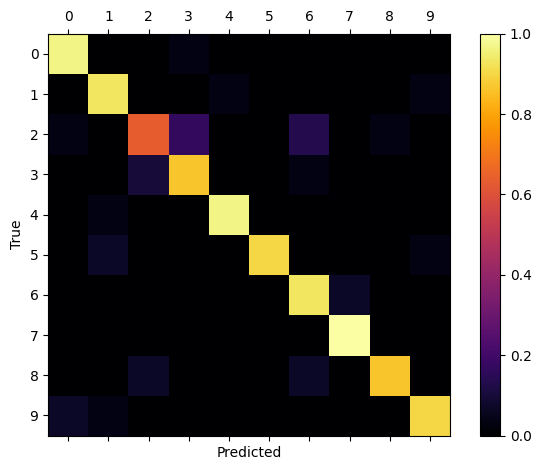

In [21]:
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(cm)
cm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.matshow(cm, fignum=0, cmap='inferno')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.yticks(range(10), labels=[str(i) for i in range(10)])
print("figure saved")
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/confmat_r6p9_cnn.pdf")
plt.show()

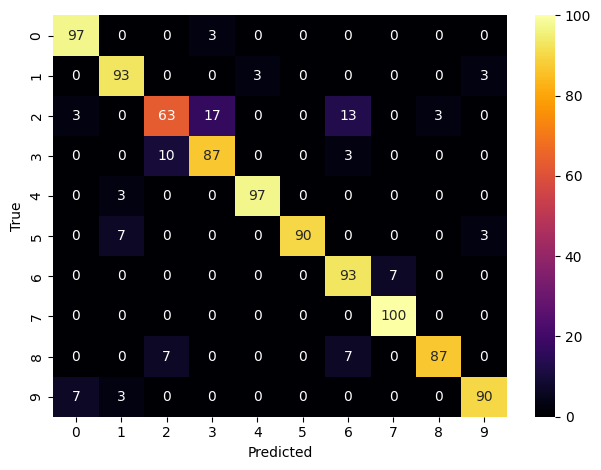

In [31]:
cm = confusion_matrix(true_labels, pred_labels)
cm = np.round(cm/cm.sum(axis=1)[:, np.newaxis]*100, decimals=0).astype(int)
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/confmat_r6p9_cnn.pdf")
plt.show()

## Doing it raw

In [1]:
## Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

In [2]:
def load_wav_files(directory):
    """Load all .wav files from a directory and return their paths."""
    wav_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    return wav_files

def pad_features(features, max_len=48):
    """Pad features to ensure they all have the same shape."""
    padded_features = []
    for feature in features:
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            padded_feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            padded_feature = feature[:, :max_len]
        padded_features.append(padded_feature)
    return np.array(padded_features)

def extract_features(file_path, n_mels=48, n_fft=256, hop_length=64):
    """Extract Mel spectrogram features from an audio file."""
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def create_dataset(file_paths):
    """Create dataset from a list of file paths."""
    features = []
    labels = []
    for file_path in file_paths:
        label = os.path.basename(file_path).split('_')[0]  # Assuming directory name is the label
        features.append(extract_features(file_path))
        labels.append(float(label))
    features = pad_features(features, max_len=48)
    return np.array(features), torch.LongTensor(labels)

def split_dataset(features, labels, test_size=0.2, random_state=42):
    """Split the dataset into training and test sets."""
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Example usage
directory = '../../Simulations/FSDD/recordings/'
wav_files = load_wav_files(directory)
features, labels = create_dataset(wav_files)
X_train, X_test, y_train, y_test = split_dataset(features, labels)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (2400, 48, 48)
Test set size: (600, 48, 48)


In [3]:
# Create datasets and dataloaders
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

test_loader = DataLoader([X_test, y_test], batch_size=1, shuffle=False)

# Define the CNN model
class SmallSpeechCNN(nn.Module):
    def __init__(self, num_classes):
        super(SmallSpeechCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(-1, 64)  # Adjusted input size for fc1
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# Initialize the model, loss function, and optimizer
num_classes = 10
model = SmallSpeechCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001 )

In [4]:
# Training loop
num_epochs = 25


for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f' Loss: {loss.item():.4f}')


  4%|▍         | 1/25 [00:21<08:39, 21.63s/it]

 Loss: 2.5146


  8%|▊         | 2/25 [01:03<12:45, 33.27s/it]

 Loss: 2.2393


 12%|█▏        | 3/25 [01:54<15:11, 41.41s/it]

 Loss: 2.5585


 16%|█▌        | 4/25 [02:43<15:32, 44.39s/it]

 Loss: 2.0411


 20%|██        | 5/25 [03:38<16:06, 48.31s/it]

 Loss: 1.8896


 24%|██▍       | 6/25 [05:22<21:15, 67.14s/it]

 Loss: 2.4552


 28%|██▊       | 7/25 [06:31<20:22, 67.91s/it]

 Loss: 2.1905


 32%|███▏      | 8/25 [07:35<18:51, 66.56s/it]

 Loss: 2.6864


 36%|███▌      | 9/25 [08:33<17:05, 64.09s/it]

 Loss: 2.8166


 40%|████      | 10/25 [09:26<15:06, 60.41s/it]

 Loss: 1.8637


 44%|████▍     | 11/25 [10:20<13:41, 58.65s/it]

 Loss: 2.1695


 48%|████▊     | 12/25 [11:28<13:20, 61.57s/it]

 Loss: 1.9628


 52%|█████▏    | 13/25 [12:30<12:20, 61.70s/it]

 Loss: 2.2943


 56%|█████▌    | 14/25 [13:35<11:26, 62.45s/it]

 Loss: 1.2459


 60%|██████    | 15/25 [14:45<10:48, 64.81s/it]

 Loss: 2.2609


 64%|██████▍   | 16/25 [15:39<09:13, 61.50s/it]

 Loss: 2.1235


 68%|██████▊   | 17/25 [16:39<08:09, 61.15s/it]

 Loss: 2.2325


 72%|███████▏  | 18/25 [17:38<07:03, 60.52s/it]

 Loss: 1.1849


 76%|███████▌  | 19/25 [18:48<06:19, 63.30s/it]

 Loss: 0.4357


 80%|████████  | 20/25 [19:56<05:24, 64.83s/it]

 Loss: 1.7235


 84%|████████▍ | 21/25 [21:05<04:24, 66.05s/it]

 Loss: 1.9929


 88%|████████▊ | 22/25 [22:06<03:13, 64.46s/it]

 Loss: 1.0612


 92%|█████████▏| 23/25 [23:10<02:08, 64.23s/it]

 Loss: 2.0951


 96%|█████████▌| 24/25 [24:18<01:05, 65.46s/it]

 Loss: 1.9891


100%|██████████| 25/25 [25:26<00:00, 61.05s/it]

 Loss: 2.4311


In [8]:
test_data = []
for i in range(len(X_test)):
   test_data.append([X_test[i], y_test[i]])
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

Accuracy of the model on the test set: 29.67%


## Raw on 1D CNN

In [36]:
## Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

#import torchaudio
#import torchaudio.transforms as transforms
import os 
import numpy as np
from tqdm import tqdm
from RSRTxReadBin.RTxReadBin import RTxReadBin
import pandas as pd


def load_wav_files(directory):
    """Load all .wav files from a directory and return their paths."""
    wav_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    return wav_files

def pad_features(features, max_len=20_000):
    """Pad features to ensure they all have the same shape."""
    padded_features = []
    for feature in features:
        if feature.shape[0] < max_len:
            pad_width = max_len - feature.shape[0]
            padded_feature = np.concatenate((feature, np.zeros((pad_width,))), axis=0)
        else:
            padded_feature = feature[:max_len]
        padded_features.append(padded_feature)
    return padded_features

def extract_features(file_path, n_mels=2, n_fft=400, hop_length=100):
    """Extract Mel spectrogram features from an audio file."""
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return y

def create_dataset(file_paths):
    """Create dataset from a list of file paths."""
    features = []
    labels = []
    for file_path in file_paths:
        label = os.path.basename(file_path).split('_')[0]  # Assuming directory name is the label
        features.append(extract_features(file_path))
        labels.append(float(label))
    features = pad_features(features, max_len=20_000)
    return torch.FloatTensor(features), torch.LongTensor(labels)

def split_dataset(features, labels, test_size=0.2, random_state=42):
    """Split the dataset into training and test sets."""
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        #print(x.shape)
        x = x.unsqueeze(0)
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(self.bn1(x))
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        #print(x.shape)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        #print(x.shape)
        x = x.squeeze(0)
        #print(x.shape)
        return F.log_softmax(x)



# Initialize the model, loss function, and optimizer
num_classes = 10
model = M5()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Load the data
wav_files = load_wav_files(directory)
features, labels = create_dataset(wav_files)
X_train, X_test, y_train, y_test = split_dataset(features, labels)


# Create datasets and dataloaders
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)


# Training loop
num_epochs = 25


for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f' Loss: {loss.item():.4f}')





  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\olive\AppData\Local\Temp\ipykernel_9888\2742448426.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
  4%|▍         | 1/25 [00:19<07:53, 19.71s/it]

 Loss: 2.2962


  8%|▊         | 2/25 [00:43<08:29, 22.15s/it]

 Loss: 2.3089


 12%|█▏        | 3/25 [01:01<07:21, 20.08s/it]

 Loss: 1.6541


 16%|█▌        | 4/25 [01:18<06:41, 19.14s/it]

 Loss: 0.8404


 20%|██        | 5/25 [01:36<06:13, 18.68s/it]

 Loss: 2.4782


 24%|██▍       | 6/25 [01:53<05:45, 18.16s/it]

 Loss: 1.3920


 28%|██▊       | 7/25 [02:10<05:16, 17.60s/it]

 Loss: 1.5187


 32%|███▏      | 8/25 [02:27<04:55, 17.38s/it]

 Loss: 1.9795


 36%|███▌      | 9/25 [02:44<04:36, 17.27s/it]

 Loss: 0.0707


 40%|████      | 10/25 [03:01<04:17, 17.15s/it]

 Loss: 0.4832


 44%|████▍     | 11/25 [03:18<03:59, 17.08s/it]

 Loss: 1.3946


 48%|████▊     | 12/25 [03:35<03:41, 17.05s/it]

 Loss: 0.0258


 52%|█████▏    | 13/25 [03:52<03:25, 17.09s/it]

 Loss: 0.2228


 56%|█████▌    | 14/25 [04:07<03:03, 16.66s/it]

 Loss: 0.1211


 60%|██████    | 15/25 [04:24<02:45, 16.54s/it]

 Loss: 0.6386


 64%|██████▍   | 16/25 [04:41<02:31, 16.83s/it]

 Loss: 0.2448


 68%|██████▊   | 17/25 [05:00<02:18, 17.37s/it]

 Loss: 0.0027


 72%|███████▏  | 18/25 [05:20<02:07, 18.18s/it]

 Loss: 0.0038


 76%|███████▌  | 19/25 [05:41<01:54, 19.12s/it]

 Loss: 0.0196


 80%|████████  | 20/25 [06:00<01:35, 19.08s/it]

 Loss: 0.0450


 84%|████████▍ | 21/25 [06:18<01:14, 18.75s/it]

 Loss: 1.0695


 88%|████████▊ | 22/25 [06:35<00:54, 18.15s/it]

 Loss: 0.0023


 92%|█████████▏| 23/25 [06:50<00:34, 17.35s/it]

 Loss: 0.0026


 96%|█████████▌| 24/25 [07:06<00:16, 16.78s/it]

 Loss: 1.1561


100%|██████████| 25/25 [07:21<00:00, 17.67s/it]

 Loss: 0.0101


In [37]:
test_data = []
for i in range(len(X_test)):
   test_data.append([X_test[i], y_test[i]])
   
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)


# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

C:\Users\olive\AppData\Local\Temp\ipykernel_9888\2742448426.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the model on the test set: 23.50%


## 1D RAW perplexity



In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np

# Preprocess audio function
def preprocess_audio(file_path, target_sr=20000):
    y, sr = librosa.load(directory+file_path, sr=8000)
    if len(y) < target_sr:
        y = np.pad(y, (0, target_sr - len(y)))
    else:
        y = y[:target_sr]
    return y

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        audio_data = preprocess_audio(file_path)
        if self.transform:
            audio_data = self.transform(audio_data)
        return torch.tensor(audio_data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Define the M5 model
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=3, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        #x = x.unsqueeze(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze(0)
        return F.log_softmax(x, dim=1)

# Example usage
directory = '../../Simulations/FSDD/recordings/'
file_paths = os.listdir(directory)  # Replace with your file paths

#Split filepath to train and test randomly
file_paths_train, file_paths_test = train_test_split(file_paths, test_size=0.2, random_state=42)
labels_train = [int(os.path.basename(file_path).split('_')[0]) for file_path in file_paths_train]
labels_test = [int(os.path.basename(file_path).split('_')[0]) for file_path in file_paths_test]

dataset = AudioDataset(file_paths_train, labels_train)


dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the model, loss function, and optimizer
model = M5(n_input=1, n_output=10)  # Adjust n_input based on your preprocessing
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

Epoch 1, Loss: 2.2859244089821975
Epoch 2, Loss: 2.063128501748045
Epoch 3, Loss: 1.475513486340642
Epoch 4, Loss: 0.940098247746937
Epoch 5, Loss: 0.6277096534015921
Epoch 6, Loss: 0.44645222392651096
Epoch 7, Loss: 0.36851257104751617
Epoch 8, Loss: 0.2934026506636292
Epoch 9, Loss: 0.24970499827296105
Epoch 10, Loss: 0.20073409864847538
Epoch 11, Loss: 0.16480187290657947
Epoch 12, Loss: 0.15049739569190934
Epoch 13, Loss: 0.12754700377077824
Epoch 14, Loss: 0.13214848122051384
Epoch 15, Loss: 0.1027525710175261
Epoch 16, Loss: 0.10326874512389016
Epoch 17, Loss: 0.08621267641078778
Epoch 18, Loss: 0.06518357026202201
Epoch 19, Loss: 0.07490987221287165
Epoch 20, Loss: 0.0739372280461608
Epoch 21, Loss: 0.05871218545540955
Epoch 22, Loss: 0.0547832888756146
Epoch 23, Loss: 0.05166757200635994
Epoch 24, Loss: 0.03634893684611901
Epoch 25, Loss: 0.0640799388902856
Epoch 26, Loss: 0.04993362226264054
Epoch 27, Loss: 0.04007630175009775
Epoch 28, Loss: 0.042995033216000754
Epoch 29, Los

In [71]:
# Multi batch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Preprocess audio function
def preprocess_audio(file_path, target_sr=20000):
    y, sr = librosa.load(directory + file_path, sr=8000)
    if len(y) < target_sr:
        y = np.pad(y, (0, target_sr - len(y)))
    else:
        y = y[:target_sr]
    return y

# Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        audio_data = preprocess_audio(file_path)
        if self.transform:
            audio_data = self.transform(audio_data)
        return torch.tensor(audio_data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Define the M5 model
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=3, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze(1)
        return F.log_softmax(x, dim=1)

# Example usage
directory = '../../Simulations/FSDD/recordings/'
file_paths = os.listdir(directory)  # Replace with your file paths

# Split filepath to train and test randomly
file_paths_train, file_paths_test = train_test_split(file_paths, test_size=0.2, random_state=42)
labels_train = [int(os.path.basename(file_path).split('_')[0]) for file_path in file_paths_train]
labels_test = [int(os.path.basename(file_path).split('_')[0]) for file_path in file_paths_test]

dataset = AudioDataset(file_paths_train, labels_train)

# Update DataLoader to use batch size of 32
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
model = M5(n_input=1, n_output=10)  # Adjust n_input based on your preprocessing
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    
    # Test the model while running the loop
    test_dataset = AudioDataset(file_paths_test, labels_test)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Loss: 2.090507688522339
Accuracy: 37.83%
Epoch 2, Loss: 1.7708391014734903
Accuracy: 9.33%
Epoch 3, Loss: 1.4898724873860678
Accuracy: 11.17%
Epoch 4, Loss: 1.2882515716552734
Accuracy: 27.17%
Epoch 5, Loss: 1.1093785651524861
Accuracy: 9.33%
Epoch 6, Loss: 0.9687022272745768
Accuracy: 21.50%
Epoch 7, Loss: 0.8598426802953084
Accuracy: 11.17%
Epoch 8, Loss: 0.7739162127176921
Accuracy: 9.33%
Epoch 9, Loss: 0.6800057991345724
Accuracy: 16.67%
Epoch 10, Loss: 0.6284170587857564
Accuracy: 37.17%
Epoch 11, Loss: 0.5366672039031982
Accuracy: 23.17%
Epoch 12, Loss: 0.4995364995797475
Accuracy: 14.67%
Epoch 13, Loss: 0.472200741370519
Accuracy: 30.83%
Epoch 14, Loss: 0.42357081174850464
Accuracy: 9.83%
Epoch 15, Loss: 0.39550186475118
Accuracy: 9.50%
Epoch 16, Loss: 0.3587249968449275
Accuracy: 18.50%
Epoch 17, Loss: 0.31505261520544686
Accuracy: 16.00%
Epoch 18, Loss: 0.31730391760667165
Accuracy: 10.17%
Epoch 19, Loss: 0.277662522594134
Accuracy: 11.00%
Epoch 20, Loss: 0.2388352321

In [70]:
# Write the test loop
test_dataset = AudioDataset(file_paths_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 10.00%
